# PCA & K-Means Cluster Analysis of Personal IMDB Ratings
### Objectives:
1. Attempting to Find patterns in IMDB Ratings over a period of 5 Years.<b> Find insights about preferences etc., Important Features </b>Using (I) EDA (II) K-Means Clustering.
2. Find <b>Interesting Clusters of Movies Using K-Means Clustering</b>, gathering Insight on preferences.
3. Use <b>Principal Component Analysis </b>to improve Clustering output.

### Idea/TO DO 
1. Could do predictive modelling to predict Your Ratings.(Bad-ish Idea, Do later)
2. Visualize, analyze clusters
3. T-Sne plot of the PCs 

### Scaling Data and Principal Component Analysis.
1. Scale Data. (Done, converted all possible values to numeric, Dropped Title, REstore from Original DF)
2. Perform PCA (87 Components explain 50% of theVariance in the Dataset) - Down from 207 Features.
3. Cluster (Doing)
4. Analzse Clusters.(Doing)
5. Visualise Clusters.
5. Profit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [47]:
path = str(Path.cwd()) + '/imdb_ratings_april_2020.csv'

data = pd.read_csv(path, engine='python', index_col=0)

## Preparing Data

1. Filtering Only Movies
2. No Null values.
3. Some incorrect Data Types, Fixed Later.
4. New Features engineered later.

In [48]:
# Filter Dataframe

film_filt = (data['Title Type'] == 'movie')
data_film = data.loc[(film_filt)]
# Keeping Backup Dataframe
data_film_orig = data_film

## 1. Exploratory Analysis & Visualizations

### Univariate 

#### BoxPlots for Quantitative Vars.
Insights:
1. Most of the Ratings lie between the rating 7 and 8, this is slightly lower compared to the IMDb users, But this could be misleading as Discrete vs Continuous Comaprison.
2. The author generally likes watching Longer Movies.
3. Although most movies watched are newer, their is a long tail towards older movies, author doesn't mind the occassional older movies.
4. Majority of the movies watched are on the lower end of Popularity. 

In [4]:
def plot_box_num_uni(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 3, i+1)
        sns.boxplot(x = str(item), data = df)
        ax.set_title(item)

    fig.show()

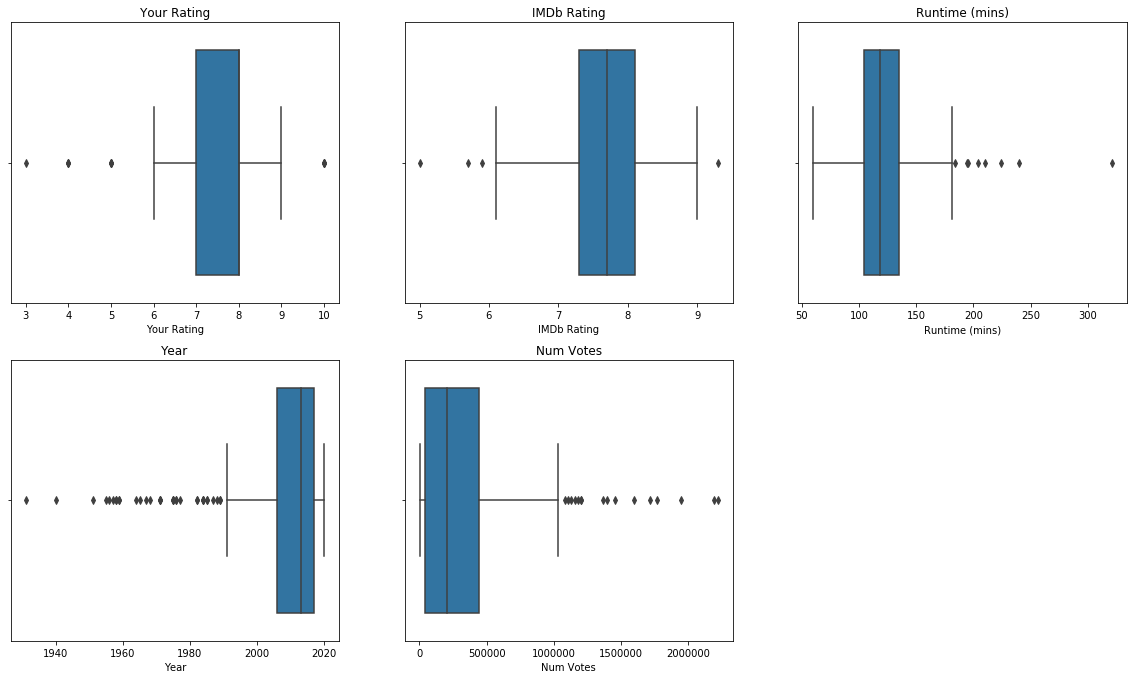

In [5]:
plot_box_num_uni(data_film)

#### Division of Ratings accross Genres

In [7]:
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.

In [8]:
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)

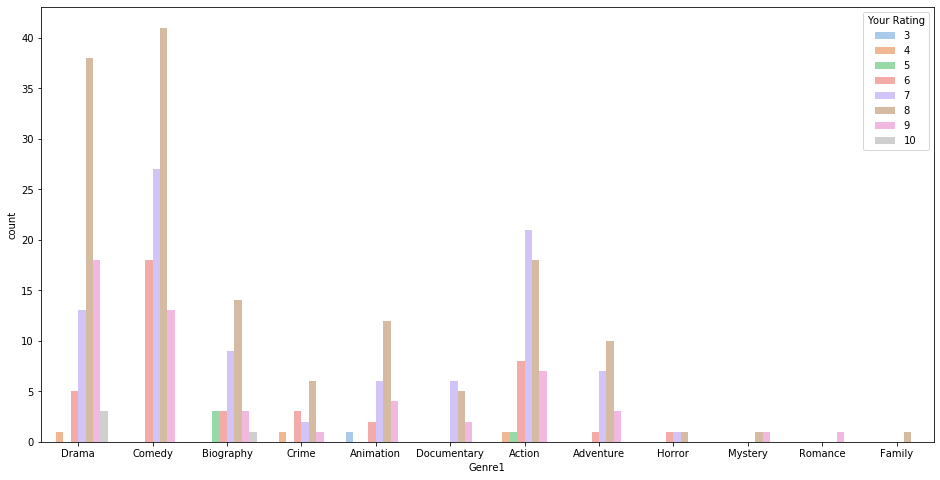

In [9]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x = 'Genre1', data = data_film, hue="Your Rating", palette="pastel")
ax.legend(loc='upper right', title = 'Your Rating')
plt.show()

#### Most Watched Directors

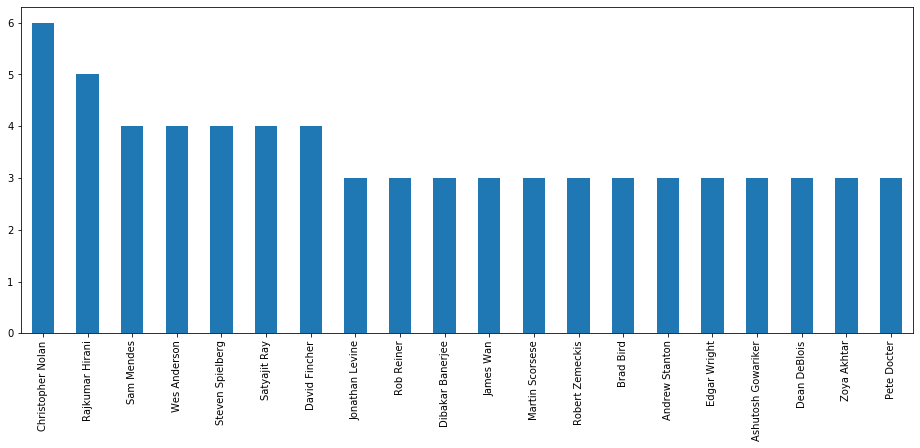

In [10]:
plt.figure(figsize = (16,6))
data_film.Director1.value_counts()[:20].plot(kind = 'bar')
plt.show()

## Bivariate Analysis With Respect to 'Your Rating'
1. I generally follow the same trends as the IMDb ratings. The movies I've rated the highest tend to be highly rated movies in general. There is a large percentage of movies I've rated lower that the IMDb public likes.
2. The lowest rated movies tend to have longer run times compared to the average movies. The highest rated movies tend to be longer too.
3. Most higher rated movies are more spread out when it comes to year of release. The violin plot shows this better.
4. There is high spread in the popularity of the movies rated higher. Will check relationship using Linear Regression later.

In [11]:
def plot_box_num_biv(df, categ):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a categorical column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 2, i+1)
        sns.boxplot(x = categ, y = str(item), data = df)
        ax.set_title(item)

    fig.show()

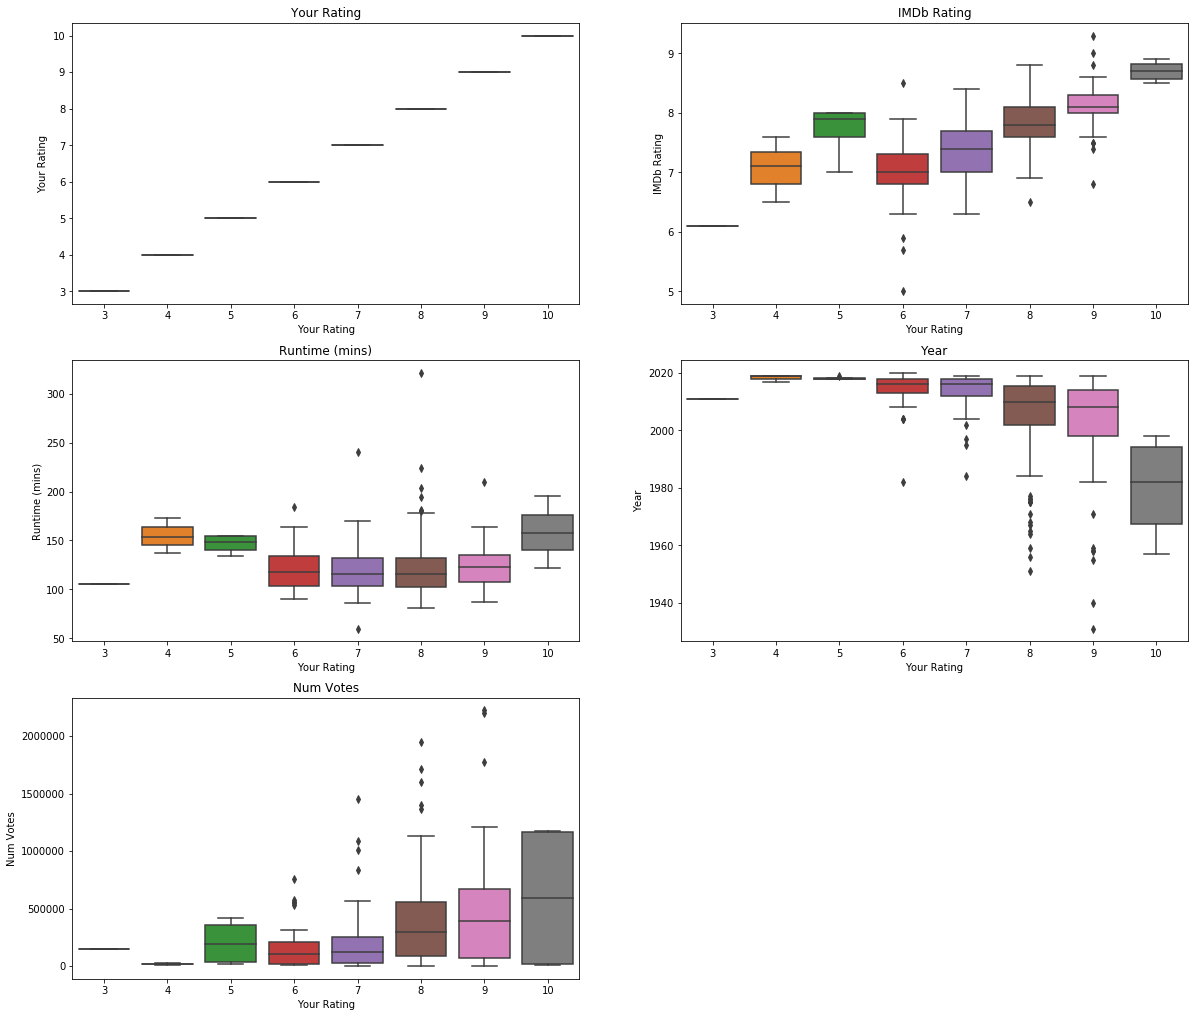

In [12]:
plot_box_num_biv(data_film, 'Your Rating')

## Checking Relationships Between Data

### Checking Pearsons Correlation 

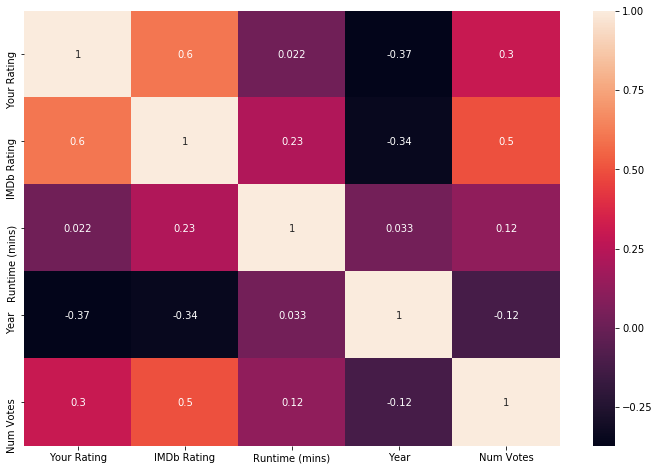

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(data = data_film.corr(), annot=True)
plt.show()

## Linear Regression Plots to check If there is a Linear Relationships between Your Rating and Other Quantitaive Vars., Comparison with IMDb Users.
0. A strong relationship is not expected between Your Ratings (sample) and IMDb Ratings (population), this is backed up by the first plot. It was observed that the std deviation for Your rating is greater, which is to be expected from a sample of size 1. But this is not of interest as we want to know which features contribute most to the Ratings and whether there is significant difference between the author and the IMDB Population.
1. There is a Strong Positive Linear Relationship between IMDb user Ratings and My Ratings, not significantly different ratings, makes sense as movies rated higher by the population would be good movies in geneal. There are quite a few outliers visible. More interested in these values as they could show possible pecularities in taste and important features.
2. No Significant Relationship linear relationship between runtime and Your rating. There are high leverage points. Weaker relationship compared to Imdb Users.
3. Appears to be weak negative relationship between Year of release and Your Rating, stronger than other IMDb users , author favors older movies but could be possible that only good older movies watched. (Check Leverage Statistics to see if this is a problem.)
4. Appears to be a weak positive relationship between popularity (Num of votes) and Your rating. Some high leverage points. Comparing with Rating by IMDb users, this relationship appears to be extremely similar but larger confidence interval. So yeah, popular movies tend to be rated higher, again could just be a correlation.

In [14]:
def plot_lin_num_biv(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a categorical column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot((len(df.select_dtypes([np.number]).columns.to_list())), 2, i+1)
        sns.regplot(y = 'Your Rating', x = str(item), data = data_film, label = 'Your Ratings')
        sns.regplot(y = 'IMDb Rating', x = str(item), data = data_film, label = 'IMDb Ratings')
        ax.legend()
        ax.set_ylabel('Rating')
        ax.set_title('IMDb Rating, Your Rating - ' + item)
    fig.show()

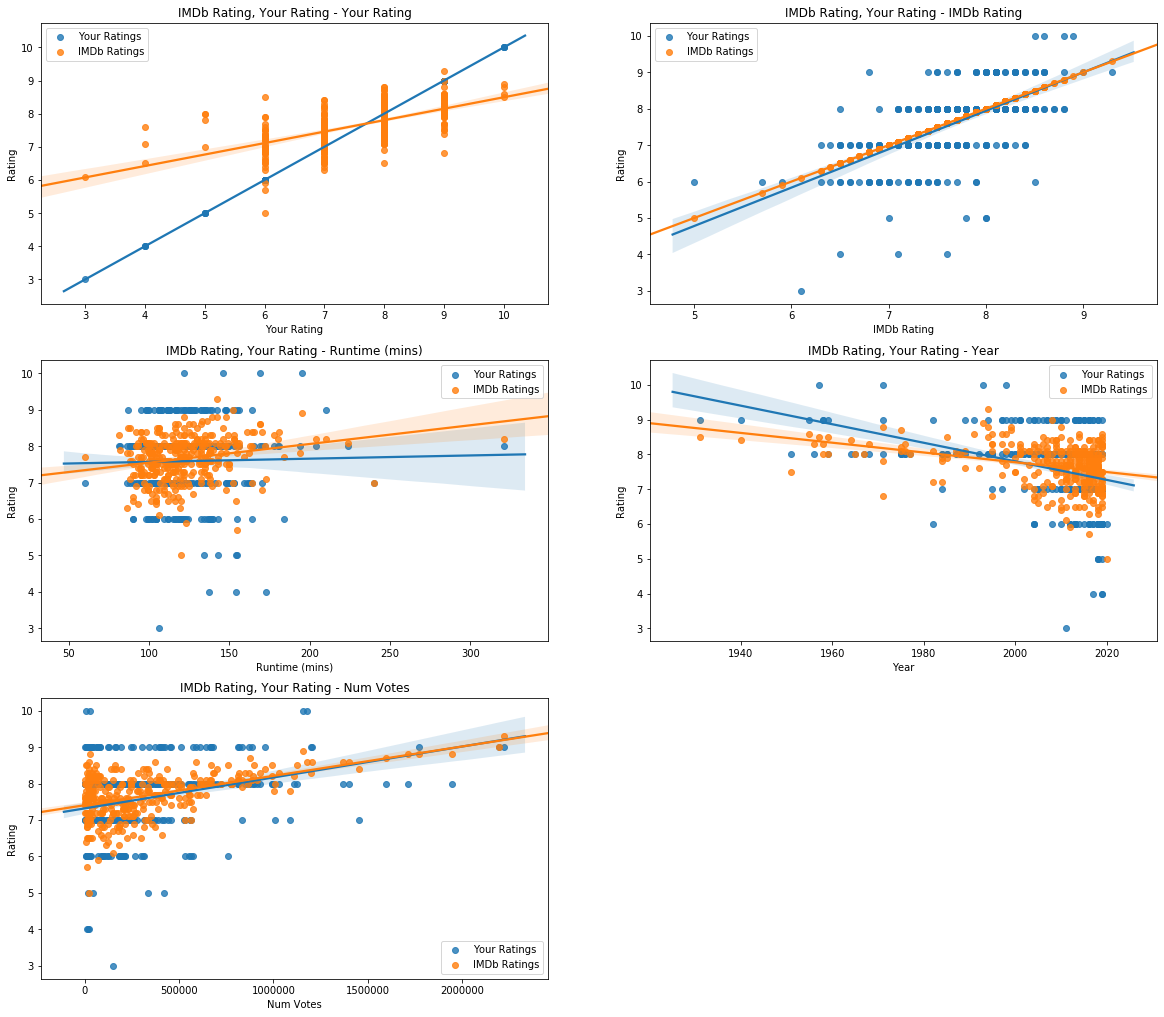

In [15]:
plot_lin_num_biv(data_film)

# 2. PCA and K-Means Clustering

### Feature Engineering, Dropping Useless columns, One-hot Encodding Categorical Column like Genre, Director etc.

In [16]:
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)

#### Lets see if we can Eye-ball clusters.

Text(0, 0.5, 'Rating')

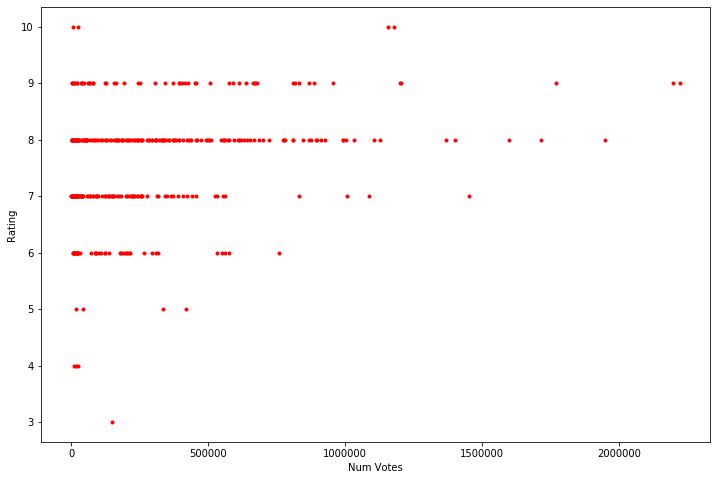

In [17]:
plt.figure(figsize=(12,8))
plt.plot( data_film['Num Votes'], data_film['Your Rating'].to_list(), 'r.')
plt.xlabel('Num Votes')
plt.ylabel('Rating')

#### Feature Engineering - One - Hot encode Genre, Directors and Dropping a few Columns, Convert Rated to Numerical

In [18]:
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)

#### Making Copy as we'll drop Title and convert to numeric

In [19]:
data_film_num = data_film
data_film_num.drop(['Title'], axis = 1, inplace=True)
data_film_num.drop(['Release_Year'], axis = 1, inplace=True)
data_film_num['Rated_Year'] = data_film_num['Rated_Year'].astype(int)

#### Visualizing New Info

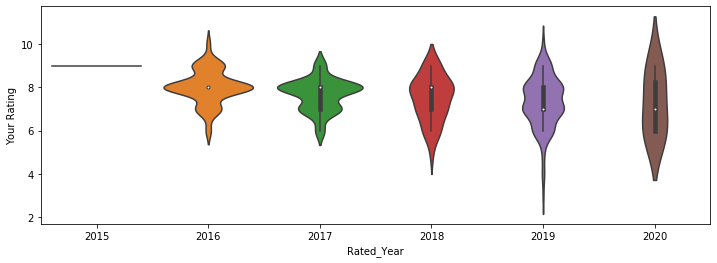

In [20]:
plt.figure(figsize=(12,4))
sns.violinplot(x = 'Rated_Year', y = 'Your Rating', data =data_film_num )

# Curse of Dimensionality - 273 Features for 345 samples. 

# Principal Components Analysis to Reduce Dimensionality of Data

#### Standardize Data

In [21]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = StandardScaler().fit_transform(data_film_num.values)

#### Restoring Indexes And Column Names

In [22]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film_num.index, columns = data_film_num.columns)

#### Lets Target that 50% Percent of the Variance is explained by the principal components - Explained by 120 Features.

In [23]:
from sklearn.decomposition import PCA

target_variance = 0.50

for i in range(len(data_film_scaled_df.columns)):
    pca_film = PCA(n_components=i)
    pca_components_film = pca_film.fit_transform(data_film_scaled_df)
    #print(f'Total Explained Variance is {np.sum(pca_film.explained_variance_ratio_)}')
    if np.sum(pca_film.explained_variance_ratio_) > target_variance:
        #print(f'No of Components that explain 50% of Variance: {i}')
        break

print(f'No of Components that explain 50% of Variance: {i}')

No of Components that explain 50% of Variance: 120


### Visualizing important Features for First Principal Component
No single features dominates, which is good.

In [25]:
first_comp = pca_film.components_[0]
# Creating Dataframe for correspoding Columns in original Dataframe
first_comps = pd.DataFrame(zip(first_comp, data_film_scaled_df.columns), columns = ['Weights', 'Features'])
first_comps['abs_weights']=first_comps['Weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)[:10]

,Weights,Features,abs_weights
1,0.458327,IMDb Rating,0.458327
0,0.408970,Your Rating,0.408970
4,0.346599,Num Votes,0.346599
3,-0.288688,Year,0.288688
9,-0.213825,Genre_Comedy,0.213825
12,0.180817,Genre_Drama,0.180817
2,0.150680,Runtime (mins),0.150680
272,-0.142391,Rated_Year,0.142391
69,0.127985,Director_Christopher Nolan,0.127985
97,0.100570,Director_Frank Darabont,0.100570


In [26]:
list_pca_film = list(pca_components_film)

## Visualizing the High Dimensional data and Principal Components using T-SNE
Some clusters are visible by eye in the tsne output of the pricipal components, lets see if the Clustering algorithm picks this up.

In [29]:
from sklearn.manifold import TSNE

In [32]:
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)
embed_pc = TSNE(n_components=2).fit_transform(pca_components_film)

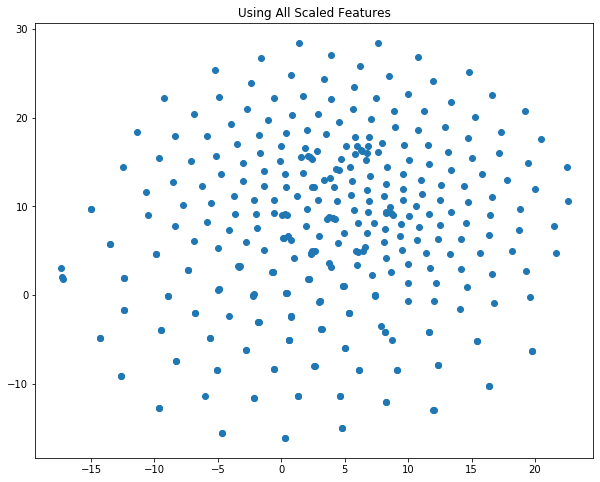

In [39]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

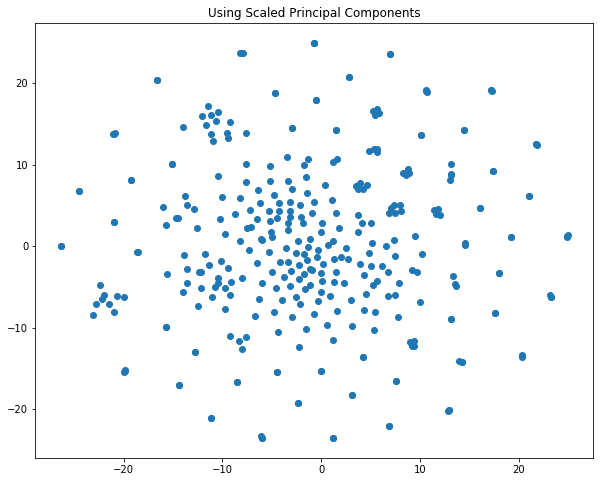

In [152]:
plt.figure(figsize=(10,8))
plt.title('Using Scaled Principal Components')
plt.scatter(embed_pc[:,:1],embed_pc[:,1:])

# Fitting Kmeans - Clustering Using Principal Components

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score
1. An Elbow somewhat appears at 85 clusters. 

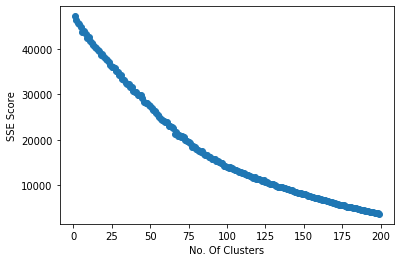

In [27]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans

distortions = []
for i in range(1,200):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100).fit(list_pca_film)
    distortions.append(cluster_film.inertia_)
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(1, 200), distortions, marker='o')
plt.savefig('Clusters_SSE_plot.jpg')

In [28]:
cluster_film = KMeans(n_clusters = 85, n_init=10, max_iter= 100).fit(list_pca_film)
pred_film = cluster_film.labels_

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [51]:
data_film_orig = data.loc[(film_filt)]
data_film_orig['Cluster'] = pred_film

# Visualizing the Clusters

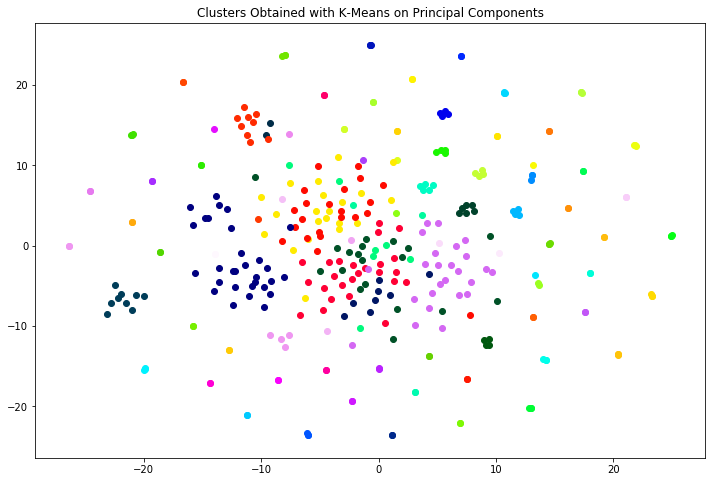

In [155]:
grouped_df = data_film_orig.groupby(['Cluster'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_pc_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 84))))
for i in range(85):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('Clusters Obtained with K-Means on Principal Components')
plt.show()

### Investigating Clusters

### Cluster Statistics - Checking Difference in Your Rating and IMDb Rating for clusters with atleast 5 movies.

In [157]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)
data_film_cluster_stats

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference
Cluster,,,
73,25,-0.532000,12.028986
62,25,0.084000,-13.611014
61,22,-0.186364,4.038076
0,21,-0.300000,8.486128
46,21,0.504762,-0.894824
5,19,-0.194737,-7.213120
59,9,-0.122222,-29.148792
84,9,-0.777778,-18.926570
6,9,-0.866667,0.073430


In [86]:
# Only Keeping clusters with atleast 5 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]

cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

122.37101449275362

In [88]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)
# Only Keeping clusters with atleast 5 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference')

,Count,RunTime_Mean_Difference
Cluster,,
18,3,-30.704348
59,9,-29.148792
8,3,-28.037681
4,4,-26.371014
43,3,-24.037681
29,3,-23.704348
17,3,-21.037681
84,9,-18.926570
48,3,-14.704348


In [91]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Num Votes'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['votes_Difference'] = data_film_orig.groupby(['Cluster'])['Num Votes'].mean() - data_film_orig['Num Votes'].mean()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)
# Only Keeping clusters with atleast 5 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Difference')

,Count,votes_Difference
Cluster,,
9,4,-3.052332e+05
39,3,-2.996703e+05
59,9,-2.940143e+05
26,3,-2.915687e+05
32,3,-2.825333e+05
33,3,-2.542507e+05
1,8,-2.160224e+05
29,3,-2.087770e+05
20,5,-1.915326e+05


In [95]:
clust_9 = grouped_df.get_group(9)
clust_9

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0048473,9,2016-09-01,Pather Panchali,https://www.imdb.com/title/tt0048473/,movie,8.6,125,1955,Drama,20749,1955-08-26,Satyajit Ray,9
tt0048956,8,2018-12-24,Aparajito,https://www.imdb.com/title/tt0048956/,movie,8.3,110,1956,Drama,10364,1956-10-11,Satyajit Ray,9
tt0051792,9,2019-06-21,Jalsaghar,https://www.imdb.com/title/tt0051792/,movie,8.0,100,1958,"Drama, Music",4761,1958-10-10,Satyajit Ray,9
tt0052572,8,2019-02-21,Apur Sansar,https://www.imdb.com/title/tt0052572/,movie,8.5,105,1959,Drama,10657,1959-05-01,Satyajit Ray,9


In [100]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Year'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['Year_diff'] = data_film_orig.groupby(['Cluster'])['Year'].mean() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)
# Only Keeping clusters with atleast 5 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_diff')

,Count,Year_diff
Cluster,,
9,4,-56.000000
18,3,-26.333333
15,3,-21.000000
11,3,-13.000000
27,4,-12.000000
40,4,-8.500000
23,7,-7.000000
46,21,-6.476190
33,3,-6.000000


## Negative Skews

In [74]:
clust_12 = grouped_df.get_group(12)
clust_12

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1457767,7,2016-10-18,The Conjuring,https://www.imdb.com/title/tt1457767/,movie,7.5,112,2013,"Horror, Mystery, Thriller",421602,2013-06-08,James Wan,12
tt1477834,5,2019-11-20,Aquaman,https://www.imdb.com/title/tt1477834/,movie,7.0,143,2018,"Action, Adventure, Fantasy, Sci-Fi",333629,2018-11-26,James Wan,12
tt3065204,6,2016-10-18,The Conjuring 2,https://www.imdb.com/title/tt3065204/,movie,7.3,134,2016,"Horror, Mystery, Thriller",212008,2016-05-13,James Wan,12


In [75]:
clust_15 = grouped_df.get_group(15)
clust_15

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0109830,8,2019-08-23,Forrest Gump,https://www.imdb.com/title/tt0109830/,movie,8.8,142,1994,"Drama, Romance",1714906,1994-06-23,Robert Zemeckis,15
tt0118884,7,2019-12-17,Contact,https://www.imdb.com/title/tt0118884/,movie,7.4,150,1997,"Drama, Mystery, Sci-Fi, Thriller",244387,1997-07-11,Robert Zemeckis,15
tt0088763,8,2018-01-04,Back to the Future,https://www.imdb.com/title/tt0088763/,movie,8.5,116,1985,"Adventure, Comedy, Sci-Fi",993402,1985-07-03,Robert Zemeckis,15


### Cluster 6 

In [57]:
clust_6 = grouped_df.get_group(6)
clust_6

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0102926,9,2019-03-19,The Silence of the Lambs,https://www.imdb.com/title/tt0102926/,movie,8.6,118,1991,"Crime, Drama, Thriller",1204991,1991-01-30,Jonathan Demme,6
tt10324144,7,2019-08-23,Article 15,https://www.imdb.com/title/tt10324144/,movie,8.2,130,2019,"Crime, Drama",18028,2019-06-20,Anubhav Sinha,6
tt1670345,6,2019-08-23,Now You See Me,https://www.imdb.com/title/tt1670345/,movie,7.3,115,2013,"Crime, Mystery, Thriller",575097,2013-05-21,Louis Leterrier,6
tt2872718,8,2019-08-16,Nightcrawler,https://www.imdb.com/title/tt2872718/,movie,7.9,117,2014,"Crime, Drama, Thriller",435476,2014-09-05,Dan Gilroy,6
tt4160708,7,2016-11-13,Don't Breathe,https://www.imdb.com/title/tt4160708/,movie,7.1,88,2016,"Crime, Horror, Thriller",204942,2016-03-12,Fede Alvarez,6
tt7286456,6,2019-11-20,Joker,https://www.imdb.com/title/tt7286456/,movie,8.5,122,2019,"Crime, Drama, Thriller",758318,2019-08-31,Todd Phillips,6
tt0780504,8,2016-10-18,Drive,https://www.imdb.com/title/tt0780504/,movie,7.8,100,2011,"Crime, Drama",547497,2011-05-20,Nicolas Winding Refn,6
tt8108198,8,2018-12-24,Andhadhun,https://www.imdb.com/title/tt8108198/,movie,8.3,139,2018,"Crime, Thriller",58947,2018-10-04,Sriram Raghavan,6
tt8983202,4,2019-10-04,Kabir Singh,https://www.imdb.com/title/tt8983202/,movie,7.1,173,2019,"Crime, Drama, Romance",23469,2019-06-20,Sandeep Reddy Vanga,6


In [58]:
clust_84 = grouped_df.get_group(84)
clust_84

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0110357,8,2019-07-02,The Lion King,https://www.imdb.com/title/tt0110357/,movie,8.5,88,1994,"Animation, Adventure, Drama, Family, Musical",897946,1994-06-12,"Rob Minkoff, Roger Allers",84
tt1216475,3,2019-10-13,Cars 2,https://www.imdb.com/title/tt1216475/,movie,6.1,106,2011,"Animation, Adventure, Comedy, Family, Sport",150562,2011-06-18,"Bradford Lewis, John Lasseter",84
tt1453405,6,2019-08-23,Monsters University,https://www.imdb.com/title/tt1453405/,movie,7.3,104,2013,"Animation, Adventure, Comedy, Family, Fantasy",308027,2013-06-05,Dan Scanlon,84
tt1772341,7,2019-08-23,Wreck-It Ralph,https://www.imdb.com/title/tt1772341/,movie,7.7,101,2012,"Animation, Adventure, Comedy, Family, Fantasy",364641,2012-11-01,Rich Moore,84
tt2294629,6,2019-08-23,Frozen,https://www.imdb.com/title/tt2294629/,movie,7.5,102,2013,"Animation, Adventure, Comedy, Family, Fantasy,...",551552,2013-11-10,"Jennifer Lee, Chris Buck",84
tt2380307,8,2018-12-24,Coco,https://www.imdb.com/title/tt2380307/,movie,8.4,105,2017,"Animation, Adventure, Family, Fantasy, Music, ...",332284,2017-10-20,"Adrian Molina, Lee Unkrich",84
tt3606752,7,2017-10-24,Cars 3,https://www.imdb.com/title/tt3606752/,movie,6.7,102,2017,"Animation, Adventure, Comedy, Family, Sport",68070,2017-06-10,Brian Fee,84
tt4633694,8,2019-02-21,Spider-Man: Into the Spider-Verse,https://www.imdb.com/title/tt4633694/,movie,8.4,117,2018,"Animation, Action, Adventure, Family, Sci-Fi",310265,2018-12-06,"Bob Persichetti, Peter Ramsey, Rodney Rothman",84
tt5311514,9,2019-02-22,Kimi no na wa.,https://www.imdb.com/title/tt5311514/,movie,8.4,106,2016,"Animation, Drama, Fantasy, Romance",164703,2016-07-03,Makoto Shinkai,84


In [59]:
clust_20 = grouped_df.get_group(20)
clust_20

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1187043,8,2016-04-27,3 Idiots,https://www.imdb.com/title/tt1187043/,movie,8.4,170,2009,"Comedy, Drama",321555,2009-12-23,Rajkumar Hirani,20
tt2338151,7,2019-08-23,PK,https://www.imdb.com/title/tt2338151/,movie,8.1,153,2014,"Comedy, Drama, Fantasy",150789,2014-12-18,Rajkumar Hirani,20
tt0374887,9,2016-09-01,Munna Bhai M.B.B.S.,https://www.imdb.com/title/tt0374887/,movie,8.1,156,2003,"Comedy, Drama, Musical",69412,2003-12-19,Rajkumar Hirani,20
tt0456144,8,2016-10-06,Lage Raho Munna Bhai,https://www.imdb.com/title/tt0456144/,movie,8.1,144,2006,"Comedy, Drama, Romance",40661,2006-09-01,Rajkumar Hirani,20
tt6452574,5,2018-11-29,Sanju,https://www.imdb.com/title/tt6452574/,movie,7.8,155,2018,"Biography, Drama",44250,2018-06-28,Rajkumar Hirani,20


In [61]:
clust_1 = grouped_df.get_group(1)
clust_1

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1592281,8,2019-06-28,Take This Waltz,https://www.imdb.com/title/tt1592281/,movie,6.5,116,2011,"Comedy, Drama",26510,2011-09-10,Sarah Polley,1
tt1981677,6,2019-08-23,Pitch Perfect,https://www.imdb.com/title/tt1981677/,movie,7.2,112,2012,"Comedy, Music, Romance",266838,2012-09-28,Jason Moore,1
tt2806788,6,2018-10-26,Fukrey,https://www.imdb.com/title/tt2806788/,movie,6.9,139,2013,"Comedy, Drama, Romance",9942,2013-06-13,Mrighdeep Lamba,1
tt0333766,6,2019-08-09,Garden State,https://www.imdb.com/title/tt0333766/,movie,7.4,102,2004,"Comedy, Drama, Romance",203876,2004-01-16,Zach Braff,1
tt7430722,4,2019-10-13,War,https://www.imdb.com/title/tt7430722/,movie,6.5,154,2019,"Action, Thriller",16551,2019-10-02,Siddharth Anand,1
tt0758752,7,2018-05-30,Love & Other Drugs,https://www.imdb.com/title/tt0758752/,movie,6.7,112,2010,"Comedy, Drama, Romance",174057,2010-11-04,Edward Zwick,1
tt0758766,7,2018-05-04,Music and Lyrics,https://www.imdb.com/title/tt0758766/,movie,6.5,104,2007,"Comedy, Music, Romance",94170,2007-02-09,Marc Lawrence,1
tt8266310,6,2019-11-15,Blinded by the Light,https://www.imdb.com/title/tt8266310/,movie,6.9,118,2019,"Comedy, Drama, Music",14805,2019-01-27,Gurinder Chadha,1


In [62]:
clust_3 = grouped_df.get_group(3)
clust_3

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1345836,7,2016-04-27,The Dark Knight Rises,https://www.imdb.com/title/tt1345836/,movie,8.4,164,2012,"Action, Adventure",1453873,2012-07-16,Christopher Nolan,3
tt1375666,8,2019-08-23,Inception,https://www.imdb.com/title/tt1375666/,movie,8.8,148,2010,"Action, Adventure, Sci-Fi, Thriller",1949275,2010-07-08,Christopher Nolan,3
tt0468569,9,2016-04-27,The Dark Knight,https://www.imdb.com/title/tt0468569/,movie,9.0,152,2008,"Action, Crime, Drama, Thriller",2197573,2008-07-14,Christopher Nolan,3
tt0482571,8,2016-11-01,The Prestige,https://www.imdb.com/title/tt0482571/,movie,8.5,130,2006,"Drama, Mystery, Sci-Fi, Thriller",1126910,2006-10-17,Christopher Nolan,3
tt5013056,8,2017-12-26,Dunkirk,https://www.imdb.com/title/tt5013056/,movie,7.9,106,2017,"Action, Drama, History, Thriller, War",511495,2017-07-13,Christopher Nolan,3
tt0816692,8,2016-04-27,Interstellar,https://www.imdb.com/title/tt0816692/,movie,8.6,169,2014,"Adventure, Drama, Sci-Fi, Thriller",1400296,2014-10-26,Christopher Nolan,3


In [63]:
clust_73 = grouped_df.get_group(73)
clust_73

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1211837,7,2018-07-11,Doctor Strange,https://www.imdb.com/title/tt1211837/,movie,7.5,115,2016,"Action, Adventure, Fantasy, Sci-Fi",562738,2016-10-13,Scott Derrickson,73
tt0133093,8,2019-06-28,The Matrix,https://www.imdb.com/title/tt0133093/,movie,8.7,136,1999,"Action, Sci-Fi",1597353,1999-03-24,"Lilly Wachowski, Lana Wachowski",73
tt1365519,6,2019-02-27,Tomb Raider,https://www.imdb.com/title/tt1365519/,movie,6.3,119,2018,"Action, Adventure, Fantasy, Thriller",180494,2018-03-02,Roar Uthaug,73
tt1392190,9,2019-08-23,Mad Max: Fury Road,https://www.imdb.com/title/tt1392190/,movie,8.1,120,2015,"Action, Adventure, Sci-Fi, Thriller",832484,2015-05-07,George Miller,73
tt1638355,7,2019-10-06,The Man from U.N.C.L.E.,https://www.imdb.com/title/tt1638355/,movie,7.3,116,2015,"Action, Adventure, Comedy",255062,2015-08-02,Guy Ritchie,73
tt2488496,7,2016-04-27,Star Wars: Episode VII - The Force Awakens,https://www.imdb.com/title/tt2488496/,movie,7.9,138,2015,"Action, Adventure, Sci-Fi",833061,2015-12-14,J.J. Abrams,73
tt2527336,7,2019-08-23,Star Wars: Episode VIII - The Last Jedi,https://www.imdb.com/title/tt2527336/,movie,7.0,152,2017,"Action, Adventure, Fantasy, Sci-Fi",532880,2017-12-09,Rian Johnson,73
tt2704998,6,2019-07-27,Game Night,https://www.imdb.com/title/tt2704998/,movie,6.9,100,2018,"Action, Comedy, Crime, Mystery",187851,2018-02-15,"Jonathan Goldstein, John Francis Daley",73
tt3019620,7,2019-10-05,Titli,https://www.imdb.com/title/tt3019620/,movie,7.6,116,2014,"Action, Drama, Thriller",3885,2014-05-20,Kanu Behl,73


In [64]:
clust_0 = grouped_df.get_group(0)
clust_0

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1024648,7,2019-10-06,Argo,https://www.imdb.com/title/tt1024648/,movie,7.7,120,2012,"Biography, Drama, Thriller",555165,2012-08-31,Ben Affleck,0
tt0103939,8,2017-04-04,Chaplin,https://www.imdb.com/title/tt0103939/,movie,7.6,143,1992,"Biography, Comedy, Drama",51518,1992-12-16,Richard Attenborough,0
tt0112573,8,2019-06-23,Braveheart,https://www.imdb.com/title/tt0112573/,movie,8.3,178,1995,"Biography, Drama, History, War",927607,1995-05-18,Mel Gibson,0
tt1485796,7,2019-08-23,The Greatest Showman,https://www.imdb.com/title/tt1485796/,movie,7.6,105,2017,"Biography, Drama, Musical",218453,2017-12-20,Michael Gracey,0
tt1504320,8,2016-04-27,The King's Speech,https://www.imdb.com/title/tt1504320/,movie,8.0,118,2010,"Biography, Drama, History",618436,2010-09-06,Tom Hooper,0
tt1596363,8,2016-04-27,The Big Short,https://www.imdb.com/title/tt1596363/,movie,7.8,130,2015,"Biography, Comedy, Drama, History",336667,2015-11-12,Adam McKay,0
tt1734110,7,2019-08-23,No One Killed Jessica,https://www.imdb.com/title/tt1734110/,movie,7.2,136,2011,"Biography, Crime, Drama, Thriller",10429,2011-01-06,Raj Kumar Gupta,0
tt1895587,9,2019-08-23,Spotlight,https://www.imdb.com/title/tt1895587/,movie,8.1,129,2015,"Biography, Crime, Drama",393982,2015-09-03,Tom McCarthy,0
tt2066051,6,2019-08-23,Rocketman,https://www.imdb.com/title/tt2066051/,movie,7.3,121,2019,"Biography, Drama, Music, Musical",108110,2019-05-16,Dexter Fletcher,0


In [65]:
clust_5 = grouped_df.get_group(5)
clust_5

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1570728,7,2017-03-29,"Crazy, Stupid, Love.",https://www.imdb.com/title/tt1570728/,movie,7.4,118,2011,"Comedy, Drama, Romance",454387,2011-07-19,"Glenn Ficarra, John Requa",5
tt1714832,7,2016-10-18,Do Dooni Chaar,https://www.imdb.com/title/tt1714832/,movie,7.6,112,2010,"Comedy, Drama",4688,2010-10-08,Habib Faisal,5
tt0211915,9,2016-04-27,Le fabuleux destin d'Am�lie Poulain,https://www.imdb.com/title/tt0211915/,movie,8.3,122,2001,"Comedy, Romance",679305,2001-04-25,Jean-Pierre Jeunet,5
tt2229499,7,2016-12-04,Don Jon,https://www.imdb.com/title/tt2229499/,movie,6.5,90,2013,"Comedy, Drama, Romance",223113,2013-01-18,Joseph Gordon-Levitt,5
tt2266600,8,2016-09-28,Hemlock Society,https://www.imdb.com/title/tt2266600/,movie,7.4,135,2012,"Comedy, Drama, Romance",2546,2012-06-22,Srijit Mukherji,5
tt0265208,6,2017-02-08,The Girl Next Door,https://www.imdb.com/title/tt0265208/,movie,6.7,109,2004,"Comedy, Drama, Romance",195796,2004-02-18,Luke Greenfield,5
tt2788710,6,2016-04-21,The Interview,https://www.imdb.com/title/tt2788710/,movie,6.5,112,2014,"Action, Adventure, Comedy",296662,2014-12-11,"Evan Goldberg, Seth Rogen",5
tt0343660,6,2018-09-01,50 First Dates,https://www.imdb.com/title/tt0343660/,movie,6.8,99,2004,"Comedy, Drama, Romance",315328,2004-02-03,Peter Segal,5
tt4385888,8,2017-05-05,20th Century Women,https://www.imdb.com/title/tt4385888/,movie,7.3,119,2016,"Comedy, Drama",36585,2016-10-08,Mike Mills,5


In [66]:
clust_61 = grouped_df.get_group(61)
clust_61

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0119217,9,2019-10-12,Good Will Hunting,https://www.imdb.com/title/tt0119217/,movie,8.3,126,1997,"Drama, Romance",816598,1997-12-02,Gus Van Sant,61
tt1517451,8,2019-11-15,A Star Is Born,https://www.imdb.com/title/tt1517451/,movie,7.7,136,2018,"Drama, Music, Romance",304647,2018-08-31,Bradley Cooper,61
tt1606389,6,2019-02-22,The Vow,https://www.imdb.com/title/tt1606389/,movie,6.8,104,2012,"Drama, Romance",179183,2012-02-06,Michael Sucsy,61
tt1620620,8,2019-06-26,The Japanese Wife,https://www.imdb.com/title/tt1620620/,movie,7.6,105,2010,"Drama, Romance",2025,2010-04-09,Aparna Sen,61
tt1655441,7,2019-08-23,The Age of Adaline,https://www.imdb.com/title/tt1655441/,movie,7.2,112,2015,"Drama, Fantasy, Romance",147123,2015-04-08,Lee Toland Krieger,61
tt0178186,8,2019-06-25,Aandhi,https://www.imdb.com/title/tt0178186/,movie,8.1,133,1975,"Drama, Romance",1293,1975-02-13,Gulzar,61
tt1798709,9,2016-10-18,Her,https://www.imdb.com/title/tt1798709/,movie,8.0,126,2013,"Drama, Romance, Sci-Fi",508227,2013-10-12,Spike Jonze,61
tt2203308,6,2019-07-03,Aashiqui 2,https://www.imdb.com/title/tt2203308/,movie,7.0,132,2013,"Drama, Music, Musical, Romance",25390,2013-04-25,Mohit Suri,61
tt4034228,8,2017-01-27,Manchester by the Sea,https://www.imdb.com/title/tt4034228/,movie,7.8,137,2016,Drama,231364,2016-01-23,Kenneth Lonergan,61


In [67]:
clust_59 = grouped_df.get_group(59)
clust_59

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1059955,8,2019-10-30,The Pixar Story,https://www.imdb.com/title/tt1059955/,movie,7.8,88,2007,Documentary,5461,2007-08-28,Leslie Iwerks,59
tt1313104,8,2019-08-23,The Cove,https://www.imdb.com/title/tt1313104/,movie,8.4,92,2009,"Documentary, Biography, Crime, History, News",46345,2009-04-25,Louie Psihoyos,59
tt1424432,9,2016-04-21,Senna,https://www.imdb.com/title/tt1424432/,movie,8.5,106,2010,"Documentary, Biography, Sport",59969,2010-10-07,Asif Kapadia,59
tt4354792,7,2019-08-23,Jai Ho,https://www.imdb.com/title/tt4354792/,movie,7.7,60,2015,"Documentary, Biography, Music",37,2015-10-22,"Deepak Gattani, Umesh Aggarwal",59
tt5278460,7,2019-08-23,Audrie & Daisy,https://www.imdb.com/title/tt5278460/,movie,7.2,95,2016,Documentary,5034,2016-01-25,"Bonni Cohen, Jon Shenk",59
tt5952332,7,2019-08-23,Amanda Knox,https://www.imdb.com/title/tt5952332/,movie,6.9,92,2016,"Documentary, Crime",19225,2016-09-10,"Rod Blackhurst, Brian McGinn",59
tt7681902,8,2019-03-08,Won't You Be My Neighbor?,https://www.imdb.com/title/tt7681902/,movie,8.4,95,2018,"Documentary, Biography",20737,2018-01-19,Morgan Neville,59
tt9358204,7,2019-07-25,The Great Hack,https://www.imdb.com/title/tt9358204/,movie,7.0,114,2019,Documentary,16254,2019-01-26,"Jehane Noujaim, Karim Amer",59
tt9412098,7,2019-07-28,Fyre,https://www.imdb.com/title/tt9412098/,movie,7.2,97,2019,"Documentary, Music",32603,2019-01-18,Chris Smith,59


### Positive Skew

In [68]:
clust_62 = grouped_df.get_group(62)
clust_62

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1022603,9,2019-06-21,(500) Days of Summer,https://www.imdb.com/title/tt1022603/,movie,7.7,95,2009,"Comedy, Drama, Romance",457030,2009-01-17,Marc Webb,62
tt0118799,9,2018-01-01,La vita � bella,https://www.imdb.com/title/tt0118799/,movie,8.6,116,1997,"Comedy, Drama, Romance, War",590686,1997-12-20,Roberto Benigni,62
tt1336608,6,2016-10-27,Rock of Ages,https://www.imdb.com/title/tt1336608/,movie,5.9,123,2012,"Comedy, Drama, Musical, Romance",71861,2012-06-13,Adam Shankman,62
tt0146882,8,2019-02-07,High Fidelity,https://www.imdb.com/title/tt0146882/,movie,7.5,113,2000,"Comedy, Drama, Music, Romance",163278,2000-03-17,Stephen Frears,62
tt1629391,7,2019-01-08,Tere Bin Laden,https://www.imdb.com/title/tt1629391/,movie,7.2,95,2010,"Comedy, Drama",9952,2010-07-16,Abhishek Sharma,62
tt1878870,7,2017-02-04,The Edge of Seventeen,https://www.imdb.com/title/tt1878870/,movie,7.3,104,2016,"Comedy, Drama",96178,2016-09-16,Kelly Fremon Craig,62
tt2194499,8,2017-09-20,About Time,https://www.imdb.com/title/tt2194499/,movie,7.8,123,2013,"Comedy, Drama, Fantasy, Romance, Sci-Fi",282794,2013-06-27,Richard Curtis,62
tt2361509,8,2016-04-21,The Intern,https://www.imdb.com/title/tt2361509/,movie,7.1,121,2015,"Comedy, Drama",205457,2015-09-15,Nancy Meyers,62
tt0272338,7,2019-11-20,Punch-Drunk Love,https://www.imdb.com/title/tt0272338/,movie,7.3,95,2002,"Comedy, Drama, Romance, Thriller",140672,2002-05-19,Paul Thomas Anderson,62


In [69]:
clust_76 = grouped_df.get_group(76)
clust_76

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0181875,9,2015-06-17,Almost Famous,https://www.imdb.com/title/tt0181875/,movie,7.9,122,2000,"Adventure, Comedy, Drama, Music",242892,2000-09-08,Cameron Crowe,76
tt3183660,7,2016-11-19,Fantastic Beasts and Where to Find Them,https://www.imdb.com/title/tt3183660/,movie,7.3,132,2016,"Adventure, Family, Fantasy",389428,2016-11-08,David Yates,76
tt0361748,9,2019-01-08,Inglourious Basterds,https://www.imdb.com/title/tt0361748/,movie,8.3,153,2009,"Adventure, Drama, War",1199785,2009-05-20,Quentin Tarantino,76
tt0371724,7,2019-08-23,The Hitchhiker's Guide to the Galaxy,https://www.imdb.com/title/tt0371724/,movie,6.8,109,2005,"Adventure, Comedy, Sci-Fi",182148,2005-04-20,Garth Jennings,76
tt0454876,8,2019-02-21,Life of Pi,https://www.imdb.com/title/tt0454876/,movie,7.9,127,2012,"Adventure, Drama, Fantasy",559772,2012-09-28,Ang Lee,76
tt5884052,6,2019-06-02,Pok�mon Detective Pikachu,https://www.imdb.com/title/tt5884052/,movie,6.6,104,2019,"Adventure, Comedy, Family, Mystery, Sci-Fi",122222,2019-05-02,Rob Letterman,76


In [70]:
clust_23 = grouped_df.get_group(23)
clust_23

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0213847,8,2019-01-30,Mal�na,https://www.imdb.com/title/tt0213847/,movie,7.5,108,2000,"Comedy, Drama, Romance, War",85097,2000-10-26,Giuseppe Tornatore,23
tt0449059,8,2019-07-02,Little Miss Sunshine,https://www.imdb.com/title/tt0449059/,movie,7.8,101,2006,"Comedy, Drama",424692,2006-01-20,"Jonathan Dayton, Valerie Faris",23
tt5164432,7,2018-08-17,"Love, Simon",https://www.imdb.com/title/tt5164432/,movie,7.6,110,2018,"Comedy, Drama, Romance",90567,2018-02-27,Greg Berlanti,23
tt5571734,9,2019-10-05,Pink,https://www.imdb.com/title/tt5571734/,movie,8.1,136,2016,"Drama, Thriller",35592,2016-09-16,Aniruddha Roy Chowdhury,23
tt5764096,8,2017-06-23,Hindi Medium,https://www.imdb.com/title/tt5764096/,movie,7.8,132,2017,"Comedy, Drama",19731,2017-05-18,Saket Chaudhary,23
tt0061722,8,2017-02-08,The Graduate,https://www.imdb.com/title/tt0061722/,movie,8.0,106,1967,"Comedy, Drama, Romance",246032,1967-12-20,Mike Nichols,23
tt7242142,8,2019-02-25,Blindspotting,https://www.imdb.com/title/tt7242142/,movie,7.4,95,2018,"Comedy, Crime, Drama",22719,2018-01-18,Carlos L�pez Estrada,23


In [71]:
clust_46 = grouped_df.get_group(46)
clust_46

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1010048,8,2016-10-18,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120,2008,"Drama, Romance",774168,2008-08-30,"Loveleen Tandan, Danny Boyle",46
tt1179933,8,2016-09-01,10 Cloverfield Lane,https://www.imdb.com/title/tt1179933/,movie,7.2,103,2016,"Drama, Horror, Mystery, Sci-Fi, Thriller",276876,2016-03-08,Dan Trachtenberg,46
tt1324059,8,2016-09-24,Wake Up Sid,https://www.imdb.com/title/tt1324059/,movie,7.6,138,2009,"Comedy, Drama, Romance",26406,2009-10-02,Ayan Mukherjee,46
tt1563738,7,2018-09-01,One Day,https://www.imdb.com/title/tt1563738/,movie,7.0,107,2011,"Drama, Romance",133081,2011-08-08,Lone Scherfig,46
tt1659337,7,2018-09-01,The Perks of Being a Wallflower,https://www.imdb.com/title/tt1659337/,movie,8.0,103,2012,"Drama, Romance",441045,2012-09-08,Stephen Chbosky,46
tt0166924,9,2019-07-08,Mulholland Dr.,https://www.imdb.com/title/tt0166924/,movie,8.0,147,2001,"Drama, Mystery, Thriller",304730,2001-05-16,David Lynch,46
tt2381111,9,2016-04-22,Brooklyn,https://www.imdb.com/title/tt2381111/,movie,7.5,117,2015,"Drama, Romance",124483,2015-01-26,John Crowley,46
tt0298203,8,2017-04-01,8 Mile,https://www.imdb.com/title/tt0298203/,movie,7.1,110,2002,"Drama, Music",239858,2002-09-08,Curtis Hanson,46
tt3170832,8,2019-08-23,Room,https://www.imdb.com/title/tt3170832/,movie,8.1,118,2015,"Drama, Thriller",344428,2015-09-04,Lenny Abrahamson,46


In [76]:
clust_4 = grouped_df.get_group(4)
clust_4

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0128445,8,2017-11-28,Rushmore,https://www.imdb.com/title/tt0128445/,movie,7.7,93,1998,"Comedy, Drama",162979,1998-09-17,Wes Anderson,4
tt2278388,9,2016-09-24,The Grand Budapest Hotel,https://www.imdb.com/title/tt2278388/,movie,8.1,99,2014,"Adventure, Comedy, Crime",671046,2014-02-06,Wes Anderson,4
tt5104604,8,2019-01-08,Isle of Dogs,https://www.imdb.com/title/tt5104604/,movie,7.9,101,2018,"Animation, Adventure, Comedy, Drama, Fantasy, ...",126458,2018-02-15,Wes Anderson,4
tt0838221,8,2017-04-20,The Darjeeling Limited,https://www.imdb.com/title/tt0838221/,movie,7.2,91,2007,"Adventure, Comedy, Drama",173114,2007-08-31,Wes Anderson,4


In [89]:
# Gowariker Movies are generally Longer
clust_33 = grouped_df.get_group(33)
clust_33

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0169102,8,2016-09-01,Lagaan: Once Upon a Time in India,https://www.imdb.com/title/tt0169102/,movie,8.1,224,2001,"Adventure, Drama, Musical, Sport",99188,2001-06-15,Ashutosh Gowariker,33
tt0367110,9,2019-01-10,"Swades: We, the People",https://www.imdb.com/title/tt0367110/,movie,8.2,210,2004,Drama,78616,2004-12-17,Ashutosh Gowariker,33
tt3859980,6,2019-08-23,Mohenjo Daro,https://www.imdb.com/title/tt3859980/,movie,5.7,155,2016,"Action, Adventure, Drama, History",10042,2016-08-11,Ashutosh Gowariker,33


In [78]:
clust_27 = grouped_df.get_group(27)
clust_27

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0108052,10,2019-06-20,Schindler's List,https://www.imdb.com/title/tt0108052/,movie,8.9,195,1993,"Biography, Drama, History",1157748,1993-11-30,Steven Spielberg,27
tt0120815,10,2016-04-27,Saving Private Ryan,https://www.imdb.com/title/tt0120815/,movie,8.6,169,1998,"Drama, War",1177511,1998-07-21,Steven Spielberg,27
tt0264464,8,2016-09-01,Catch Me If You Can,https://www.imdb.com/title/tt0264464/,movie,8.1,141,2002,"Biography, Crime, Drama",775554,2002-12-16,Steven Spielberg,27
tt0983193,7,2019-02-21,The Adventures of Tintin,https://www.imdb.com/title/tt0983193/,movie,7.3,107,2011,"Animation, Action, Adventure, Family, Mystery",209900,2011-10-23,Steven Spielberg,27


In [79]:
clust_17 = grouped_df.get_group(17)
clust_17

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt1646971,8,2016-12-17,How to Train Your Dragon 2,https://www.imdb.com/title/tt1646971/,movie,7.8,102,2014,"Animation, Action, Adventure, Family, Fantasy",293239,2014-05-16,Dean DeBlois,17
tt2386490,8,2019-03-29,How to Train Your Dragon: The Hidden World,https://www.imdb.com/title/tt2386490/,movie,7.5,104,2019,"Animation, Action, Adventure, Family, Fantasy",91033,2019-01-03,Dean DeBlois,17
tt0892769,9,2016-04-27,How to Train Your Dragon,https://www.imdb.com/title/tt0892769/,movie,8.1,98,2010,"Animation, Action, Adventure, Family, Fantasy",639928,2010-03-18,"Dean DeBlois, Chris Sanders",17


In [80]:
clust_51 = grouped_df.get_group(51)
clust_51

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Cluster
Const,,,,,,,,,,,,,
tt0365748,8,2016-11-26,Shaun of the Dead,https://www.imdb.com/title/tt0365748/,movie,7.9,99,2004,"Comedy, Horror",493773,2004-03-29,Edgar Wright,51
tt3890160,9,2017-09-20,Baby Driver,https://www.imdb.com/title/tt3890160/,movie,7.6,113,2017,"Action, Crime, Drama, Music, Thriller",406064,2017-03-11,Edgar Wright,51
tt0446029,8,2016-11-26,Scott Pilgrim vs. the World,https://www.imdb.com/title/tt0446029/,movie,7.5,112,2010,"Action, Comedy, Fantasy, Romance",357905,2010-07-27,Edgar Wright,51


### The splits are still Mostly on the basis of ratings.

In [148]:
clust_0 = grouped_df.get_group(0)
clust_1 = grouped_df.get_group(1)
clust_2 = grouped_df.get_group(2)
clust_3 = grouped_df.get_group(3)
clust_4 = grouped_df.get_group(4)


# Appaears to be cluster of comedies, Mostly New Movies
clust_5 = grouped_df.get_group(5)

# Appears to be Cluster of Biographies, Dramas, Mostly new Movies
clust_16 = grouped_df.get_group(16)

# Appears to be Newer Action Movies
clust_21 = grouped_df.get_group(21)

# Appears to be Dramas
clust_28 = grouped_df.get_group(28)

# lower Rated Comedies
clust_31 = grouped_df.get_group(31)

# Slightly older comedy- Dramas, rated higher
clust_35 = grouped_df.get_group(35)

Clusters
0      3
1      6
2      2
3      2
4     11
5      3
6      3
7      4
8     32
9      2
10     4
11     1
12     2
13     3
14     7
15     4
16     2
17     3
18     3
19    21
20     1
21     2
22     4
23     1
24     2
25     5
26     2
27     3
28     2
29     9
30     2
31     2
32     4
33     2
34     1
35     3
36     1
37     3
38     2
39     2
40     2
41    20
42     2
43     2
44     2
45     2
46     2
47     2
48     3
49    31
50     5
51     2
52     3
53     2
54     2
55     3
56     2
57     2
58     2
59     2
60     2
61     2
62     2
63     2
64     1
65     3
66     7
67     1
68     2
69     3
70     8
71     2
72     1
73     2
74     1
75    23
76     1
77     3
78     1
79     1
80     2
81     1
82     1
83     1
84     8
Name: Your Rating, dtype: int64

In [322]:
#data_film_orig.groupby(['Clusters'])['Your Rating'].mean()
# A group of movies that is highly rated and a group with low ratings.
# Lets investigate these groups 

In [164]:
data_film_orig.loc[data_film_orig['Title'] == 'The Cove']

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Num Votes,Release Date,Genre1,Director1,Clusters
Const,,,,,,,,,,,,,
tt1313104,8,2019-08-23,The Cove,https://www.imdb.com/title/tt1313104/,movie,8.4,92,2009,46345,2009-04-25,Documentary,Louie Psihoyos,66


In [166]:
clust_13 = grouped_df.get_group(4)

clust_13.head(100)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Num Votes,Release Date,Genre1,Director1,Clusters
Const,,,,,,,,,,,,,
tt0111161,9,2019-06-20,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142,1994,2222896,1994-09-10,Drama,Frank Darabont,4
tt0119217,9,2019-10-12,Good Will Hunting,https://www.imdb.com/title/tt0119217/,movie,8.3,126,1997,816598,1997-12-02,Drama,Gus Van Sant,4
tt0213847,8,2019-01-30,Mal�na,https://www.imdb.com/title/tt0213847/,movie,7.5,108,2000,85097,2000-10-26,Comedy,Giuseppe Tornatore,4
tt2911666,8,2019-01-08,John Wick,https://www.imdb.com/title/tt2911666/,movie,7.4,101,2014,504259,2014-09-19,Action,David Leitch,4
tt0449059,8,2019-07-02,Little Miss Sunshine,https://www.imdb.com/title/tt0449059/,movie,7.8,101,2006,424692,2006-01-20,Comedy,Jonathan Dayton,4
tt5164432,7,2018-08-17,"Love, Simon",https://www.imdb.com/title/tt5164432/,movie,7.6,110,2018,90567,2018-02-27,Comedy,Greg Berlanti,4
tt5571734,9,2019-10-05,Pink,https://www.imdb.com/title/tt5571734/,movie,8.1,136,2016,35592,2016-09-16,Drama,Aniruddha Roy Chowdhury,4
tt0061722,8,2017-02-08,The Graduate,https://www.imdb.com/title/tt0061722/,movie,8.0,106,1967,246032,1967-12-20,Comedy,Mike Nichols,4
tt7242142,8,2019-02-25,Blindspotting,https://www.imdb.com/title/tt7242142/,movie,7.4,95,2018,22719,2018-01-18,Comedy,Carlos L�pez Estrada,4


### Cluster 2 Has largest Skew of negative votes from me.
Rajkumar Hirani Movies - Negative Skew mostly due to Sanju.
Check p value for statistical significance.

In [387]:
clust_2 = grouped_df.get_group(2)

clust_2.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1187043,8,2016-04-27,3 Idiots,https://www.imdb.com/title/tt1187043/,movie,8.4,170,2009,"Comedy, Drama",289841,2009-12-23,Rajkumar Hirani,2
tt2338151,8,2016-09-01,PK,https://www.imdb.com/title/tt2338151/,movie,8.2,153,2014,"Comedy, Drama, Fantasy, Sci-Fi",131980,2014-12-18,Rajkumar Hirani,2
tt0374887,9,2016-09-01,Munna Bhai M.B.B.S.,https://www.imdb.com/title/tt0374887/,movie,8.2,156,2003,"Comedy, Drama, Musical",62644,2003-12-19,Rajkumar Hirani,2
tt0456144,8,2016-10-06,Lage Raho Munna Bhai,https://www.imdb.com/title/tt0456144/,movie,8.1,144,2006,"Comedy, Drama, Fantasy, Romance",37247,2006-09-01,Rajkumar Hirani,2
tt6452574,5,2018-11-29,Sanju,https://www.imdb.com/title/tt6452574/,movie,8.0,155,2018,"Biography, Drama",36819,2018-06-28,Rajkumar Hirani,2


### Cluster - 8
Hindi Movies I tend to rate lower, significant cluster since there is no language information in original dataset.

In [390]:
clust_8 = grouped_df.get_group(8)

clust_8.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1093370,9,2018-06-13,Jab We Met,https://www.imdb.com/title/tt1093370/,movie,7.9,138,2007,"Comedy, Drama, Romance",41057,2007-10-26,Imtiaz Ali,8
tt0120338,8,2018-09-22,Titanic,https://www.imdb.com/title/tt0120338/,movie,7.8,194,1997,"Drama, Romance",929842,1997-11-01,James Cameron,8
tt1839596,7,2016-09-01,Rockstar,https://www.imdb.com/title/tt1839596/,movie,7.7,159,2011,"Drama, Music, Musical, Romance",33703,2011-11-11,Imtiaz Ali,8
tt1954470,8,2016-10-18,Gangs of Wasseypur,https://www.imdb.com/title/tt1954470/,movie,8.2,321,2012,"Action, Comedy, Crime, Drama, Thriller",66854,2012-05-22,Anurag Kashyap,8
tt5074352,8,2019-01-08,Dangal,https://www.imdb.com/title/tt5074352/,movie,8.5,161,2016,"Action, Biography, Drama, Sport",113222,2016-12-21,Nitesh Tiwari,8


### Cluster 31, Comedies 
No likee

In [400]:
clust_31.head(2)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1336608,6,2016-10-27,Rock of Ages,https://www.imdb.com/title/tt1336608/,movie,5.9,123,2012,"Comedy, Drama, Musical, Romance",68961,2012-06-13,Adam Shankman,31
tt1570728,7,2017-03-29,"Crazy, Stupid, Love.",https://www.imdb.com/title/tt1570728/,movie,7.4,118,2011,"Comedy, Drama, Romance",429685,2011-07-19,"Glenn Ficarra, John Requa",31


## Positive Skews

### Cluster 27 - Older Popular Dramas
Rate Highly

In [401]:
clust_27.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt0111161,10,2017-02-04,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142,1994,Drama,2039088,1994-09-10,Frank Darabont,27
tt0061722,8,2017-02-08,The Graduate,https://www.imdb.com/title/tt0061722/,movie,8.0,106,1967,"Comedy, Drama, Romance",234011,1967-12-21,Mike Nichols,27
tt0066763,10,2016-09-01,Anand,https://www.imdb.com/title/tt0066763/,movie,8.8,122,1971,Drama,21909,1971-03-12,Hrishikesh Mukherjee,27
tt0073486,9,2017-04-01,One Flew Over the Cuckoo's Nest,https://www.imdb.com/title/tt0073486/,movie,8.7,133,1975,Drama,809931,1975-11-19,Milos Forman,27
tt0095953,9,2018-12-23,Rain Man,https://www.imdb.com/title/tt0095953/,movie,8.0,133,1988,Drama,433634,1988-12-12,Barry Levinson,27


### Cluster 4 - Documentaries, Rated Highly

In [408]:
clust_4.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1313104,9,2017-01-22,The Cove,https://www.imdb.com/title/tt1313104/,movie,8.4,92,2009,"Documentary, Crime",44623,2009-04-25,Louie Psihoyos,4
tt1424432,9,2016-04-21,Senna,https://www.imdb.com/title/tt1424432/,movie,8.6,106,2010,"Documentary, Biography, Sport",53164,2010-10-07,Asif Kapadia,4
tt2518788,9,2015-06-07,1,https://www.imdb.com/title/tt2518788/,movie,8.0,112,2013,"Documentary, History, Sport",3307,2013-09-19,Paul Crowder,4
tt4354792,8,2019-01-11,Jai Ho,https://www.imdb.com/title/tt4354792/,movie,7.8,60,2014,"Documentary, Biography, Music",33,NaN,Umesh Aggarwal,4
tt4875844,8,2017-03-03,The 24 Hour War,https://www.imdb.com/title/tt4875844/,movie,7.3,99,2016,"Documentary, History",682,2016-12-31,"Nate Adams, Adam Carolla",4


### cluster 28,  Dramas, Romance, war, Music

In [410]:
clust_28.head(2)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1010048,8,2016-10-18,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120,2008,"Drama, Romance",733122,2008-08-30,"Loveleen Tandan, Danny Boyle",28
tt0112471,8,2018-09-22,Before Sunrise,https://www.imdb.com/title/tt0112471/,movie,8.1,101,1995,"Drama, Romance",231547,1995-01-19,Richard Linklater,28


### Cluster 35 - Comedy - Drama

In [411]:
clust_35

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1022603,8,2016-12-17,(500) Days of Summer,https://www.imdb.com/title/tt1022603/,movie,7.7,95,2009,"Comedy, Drama, Romance",432979,2009-01-17,Marc Webb,35
tt1033575,8,2016-12-17,The Descendants,https://www.imdb.com/title/tt1033575/,movie,7.3,115,2011,"Comedy, Drama",221377,2011-09-02,Alexander Payne,35
tt0118799,9,2018-01-01,La vita � bella,https://www.imdb.com/title/tt0118799/,movie,8.6,116,1997,"Comedy, Drama, Romance, War",534947,1997-12-20,Roberto Benigni,35
tt0120382,9,2016-09-01,The Truman Show,https://www.imdb.com/title/tt0120382/,movie,8.1,103,1998,"Comedy, Drama, Sci-Fi",815410,1998-06-01,Peter Weir,35
tt1306980,8,2016-12-04,50/50,https://www.imdb.com/title/tt1306980/,movie,7.7,100,2011,"Comedy, Drama, Romance",296897,2011-09-12,Jonathan Levine,35
tt1714832,7,2016-10-18,Do Dooni Chaar,https://www.imdb.com/title/tt1714832/,movie,7.6,112,2010,"Comedy, Drama",4377,2010-10-08,Habib Faisal,35
tt0088847,8,2016-04-27,The Breakfast Club,https://www.imdb.com/title/tt0088847/,movie,7.9,97,1985,"Comedy, Drama",310854,1985-02-07,John Hughes,35
tt0097165,10,2016-04-27,Dead Poets Society,https://www.imdb.com/title/tt0097165/,movie,8.1,128,1989,"Comedy, Drama",355592,1989-06-02,Peter Weir,35


In [388]:
#data_film_orig.groupby(['Clusters'])['Your Rating'].mean() - data_film_orig.groupby(['Clusters'])['IMDb Rating'].mean()


# Low standard Deviation in ratings, so, probably has clustered some sort of relationship.

In [339]:
clust_12 = grouped_df.get_group(12)

In [340]:
clust_12.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt0114709,8,2017-12-11,Toy Story,https://www.imdb.com/title/tt0114709/,movie,8.3,81,1995,"Animation, Adventure, Comedy, Family, Fantasy",768734,1995-11-19,John Lasseter,12
tt1216475,5,2017-10-24,Cars 2,https://www.imdb.com/title/tt1216475/,movie,6.2,106,2011,"Animation, Adventure, Comedy, Family, Sport",132628,2011-06-18,"John Lasseter, Brad Lewis",12
tt0317219,7,2016-11-07,Cars,https://www.imdb.com/title/tt0317219/,movie,7.1,117,2006,"Animation, Comedy, Family, Sport",318006,2006-03-14,"John Lasseter, Joe Ranft",12


In [334]:
# Movies by Spielberg
clust_15 = grouped_df.get_group(15)

clust_15.head()

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt0120815,10,2016-04-27,Saving Private Ryan,https://www.imdb.com/title/tt0120815/,movie,8.6,169,1998,"Drama, War",1076831,1998-07-21,Steven Spielberg,15
tt0264464,8,2016-09-01,Catch Me If You Can,https://www.imdb.com/title/tt0264464/,movie,8.1,141,2002,"Biography, Crime, Drama",693452,2002-12-16,Steven Spielberg,15


In [406]:
clust_16.head(3)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1024648,8,2016-04-27,Argo,https://www.imdb.com/title/tt1024648/,movie,7.7,120,2012,"Biography, Drama, Thriller",525225,2012-08-31,Ben Affleck,16
tt0103939,8,2017-04-04,Chaplin,https://www.imdb.com/title/tt0103939/,movie,7.6,143,1992,"Biography, Comedy, Drama",48783,1992-12-16,Richard Attenborough,16
tt1485796,8,2018-07-01,The Greatest Showman,https://www.imdb.com/title/tt1485796/,movie,7.7,105,2017,"Biography, Drama, Musical",181598,2017-12-20,Michael Gracey,16


In [405]:
clust_21.head(4)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1211837,7,2018-07-11,Doctor Strange,https://www.imdb.com/title/tt1211837/,movie,7.5,115,2016,"Action, Adventure, Fantasy, Sci-Fi",472650,2016-10-13,Scott Derrickson,21
tt1392190,9,2016-10-18,Mad Max: Fury Road,https://www.imdb.com/title/tt1392190/,movie,8.1,120,2015,"Action, Adventure, Sci-Fi, Thriller",755029,2015-05-07,George Miller,21
tt1431045,8,2016-04-27,Deadpool,https://www.imdb.com/title/tt1431045/,movie,8.0,108,2016,"Action, Adventure, Comedy, Sci-Fi",788580,2016-01-21,Tim Miller,21
tt1631867,9,2017-03-10,Edge of Tomorrow,https://www.imdb.com/title/tt1631867/,movie,7.9,113,2014,"Action, Sci-Fi",532590,2014-05-28,Doug Liman,21


In [402]:
clust_28.head(5)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1010048,8,2016-10-18,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120,2008,"Drama, Romance",733122,2008-08-30,"Loveleen Tandan, Danny Boyle",28
tt0112471,8,2018-09-22,Before Sunrise,https://www.imdb.com/title/tt0112471/,movie,8.1,101,1995,"Drama, Romance",231547,1995-01-19,Richard Linklater,28
tt1179933,8,2016-09-01,10 Cloverfield Lane,https://www.imdb.com/title/tt1179933/,movie,7.2,103,2016,"Drama, Horror, Mystery, Sci-Fi, Thriller",252596,2016-03-08,Dan Trachtenberg,28
tt0119217,10,2016-09-05,Good Will Hunting,https://www.imdb.com/title/tt0119217/,movie,8.3,126,1997,"Drama, Romance",746131,1997-12-02,Gus Van Sant,28
tt1193138,8,2016-12-17,Up in the Air,https://www.imdb.com/title/tt1193138/,movie,7.4,109,2009,"Drama, Romance",297043,2009-09-05,Jason Reitman,28


In [403]:
clust_31.head(4)
# Generally Rate Comedies Lower

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1336608,6,2016-10-27,Rock of Ages,https://www.imdb.com/title/tt1336608/,movie,5.9,123,2012,"Comedy, Drama, Musical, Romance",68961,2012-06-13,Adam Shankman,31
tt1570728,7,2017-03-29,"Crazy, Stupid, Love.",https://www.imdb.com/title/tt1570728/,movie,7.4,118,2011,"Comedy, Drama, Romance",429685,2011-07-19,"Glenn Ficarra, John Requa",31
tt1629391,7,2019-01-08,Tere Bin Laden,https://www.imdb.com/title/tt1629391/,movie,7.2,95,2010,"Comedy, Drama",9685,2010-07-16,Abhishek Sharma,31
tt1981677,7,2017-04-01,Pitch Perfect,https://www.imdb.com/title/tt1981677/,movie,7.2,112,2012,"Comedy, Music, Romance",250277,2012-09-28,Jason Moore,31


In [404]:
clust_35.head(4)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt1022603,8,2016-12-17,(500) Days of Summer,https://www.imdb.com/title/tt1022603/,movie,7.7,95,2009,"Comedy, Drama, Romance",432979,2009-01-17,Marc Webb,35
tt1033575,8,2016-12-17,The Descendants,https://www.imdb.com/title/tt1033575/,movie,7.3,115,2011,"Comedy, Drama",221377,2011-09-02,Alexander Payne,35
tt0118799,9,2018-01-01,La vita � bella,https://www.imdb.com/title/tt0118799/,movie,8.6,116,1997,"Comedy, Drama, Romance, War",534947,1997-12-20,Roberto Benigni,35
tt0120382,9,2016-09-01,The Truman Show,https://www.imdb.com/title/tt0120382/,movie,8.1,103,1998,"Comedy, Drama, Sci-Fi",815410,1998-06-01,Peter Weir,35


In [332]:
# Highly rated older Dramas.
clust_27 = grouped_df.get_group(27)
clust_27.head(25)

,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Clusters
Const,,,,,,,,,,,,,
tt0111161,10,2017-02-04,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142,1994,Drama,2039088,1994-09-10,Frank Darabont,27
tt0061722,8,2017-02-08,The Graduate,https://www.imdb.com/title/tt0061722/,movie,8.0,106,1967,"Comedy, Drama, Romance",234011,1967-12-21,Mike Nichols,27
tt0066763,10,2016-09-01,Anand,https://www.imdb.com/title/tt0066763/,movie,8.8,122,1971,Drama,21909,1971-03-12,Hrishikesh Mukherjee,27
tt0073486,9,2017-04-01,One Flew Over the Cuckoo's Nest,https://www.imdb.com/title/tt0073486/,movie,8.7,133,1975,Drama,809931,1975-11-19,Milos Forman,27
tt0095953,9,2018-12-23,Rain Man,https://www.imdb.com/title/tt0095953/,movie,8.0,133,1988,Drama,433634,1988-12-12,Barry Levinson,27


#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [66]:
# Lets perform 1 sample t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

pop_film = data_film['Your Rating'].tolist()
print(np.mean(pop_film), len(pop_film))

clust_3_sample = clust_3['Your Rating'].tolist()
print(np.mean(clust_3_sample), len(clust_3_sample))

tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
print('\n T-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
print('T-critical for n = {}, alpha = 0.05 is'.format(len(clust_3_sample)-1))
if pvalue<0.05:
    print('Statisttically significant result, but have read that with large enough sample size, most differences are statistically significant')

7.896 250
8.590909090909092 22

 T-Stat for hypothesis test 4.439771794851792 and P-value 0.00022703454144251792
T-critical for n = 21, alpha = 0.05 is
Statisttically significant result, but have read that with large enough sample size, most differences are statistically significant


#### 2 Sample T-Test for independent sample to compare your rating from two clusters.

In [76]:
from scipy.stats import ttest_ind

In [77]:
clust_2_sample = clust_2['Your Rating'].tolist()
clust_3_sample = clust_3['Your Rating'].tolist()

In [78]:
tstat, pvalue = ttest_ind(clust_2_sample, clust_3_sample)

In [83]:
from scipy.stats import t

In [81]:
print('Sample means 1: {}, 2: {}'.format(np.mean(clust_2_sample), np.mean(clust_3_sample)))
print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
print('T-critical for Degrees of freedom = {}, alpha = 0.05 is'.format(len(clust_2_sample) + len(clust_3_sample) - 2, t.ppf()))
if pvalue<0.05:
    print('Statisttically significant result, but have read that with large enough sample size, most differences are statistically significant.')
else:
    print('Difference not statistically different.')

Sample means 1: 8.363636363636363, 2: 8.590909090909092

T-Stat for hypothesis test -1.2820117729284253 and P-value 0.2044631953357978
T-critical for Degrees of freedom = 64, alpha = 0.05 is
Difference not statistically different.


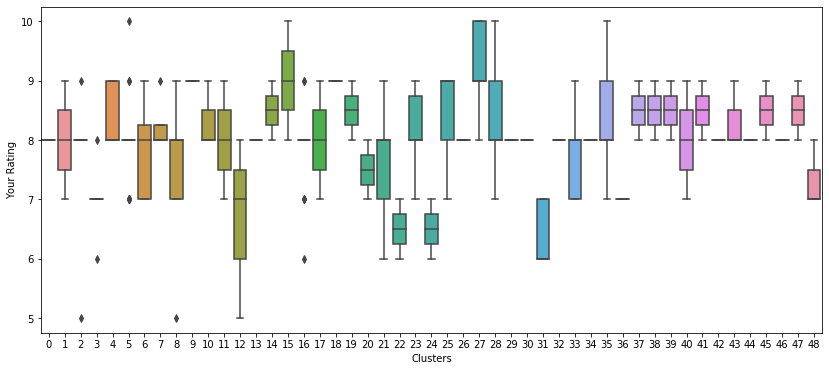

In [395]:
plt.figure(figsize=(14,6))
sns.boxplot(x = 'Clusters', y = 'Your Rating', data = data_film)

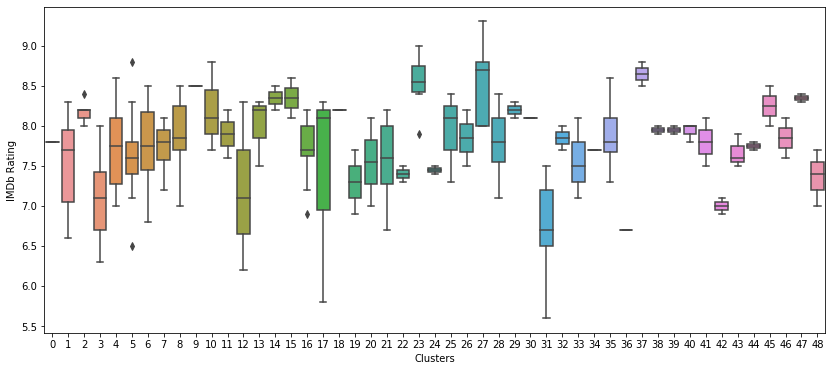

In [396]:
plt.figure(figsize=(14,6))
sns.boxplot(x = 'Clusters', y = 'IMDb Rating', data = data_film)

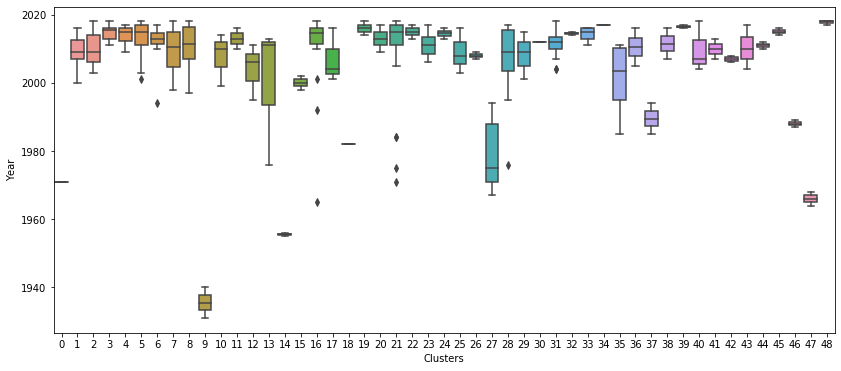

In [397]:
plt.figure(figsize=(14,6))
sns.boxplot(x = 'Clusters', y = 'Year', data = data_film)

#### Insight: I tend to rate newer movies lower that tend to have higher IMDb scores due to recency bias.

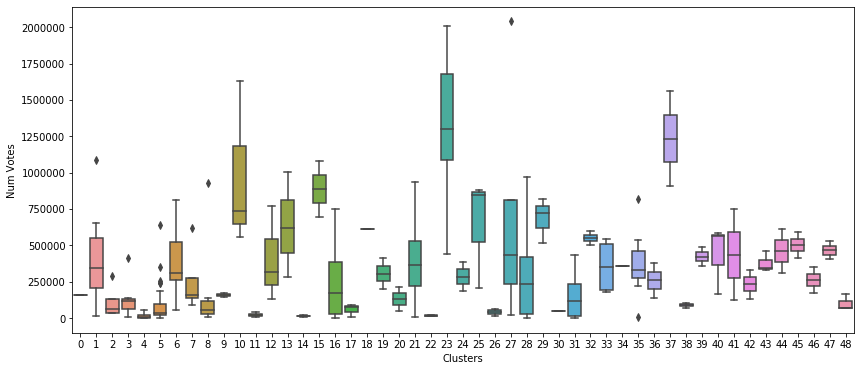

In [398]:
plt.figure(figsize=(14,6))
sns.boxplot(x = 'Clusters', y = 'Num Votes', data = data_film)